### Import Libraries

In [2]:
import math
import json
import librosa
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn.metrics import confusion_matrix

C:\Users\alexa\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
audio_dataset_path="C:/Users/alexa/Documents/Studium/Bachelor/Data4/genres_original"
metadata=pd.read_csv("C:/Users/alexa/Documents/Studium/Bachelor/Data4/features_30_sec.csv")
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [5]:
#metadata.drop(labels=552, axis=0, inplace=True)

   
    
    
    
    




In [5]:
from tqdm import tqdm

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]
        file_name=os.path.join(os.path.abspath(audio_dataset_path),final_class_labels+'/',str(row["filename"]))
        data=features_extractor(file_name)
        extracted_features.append([data, final_class_labels])
    except Exception as e:
        print("Error: {e}")
        continue

554it [00:36,  9.95it/s]C:\Users\alexa\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
556it [00:36,  8.36it/s]

Error: {e}


1000it [01:05, 15.23it/s]


In [6]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['MFCCs','class'])
extracted_features_df.head()


,MFCCs,class
0,"[-113.59882, 121.57067, -19.162262, 42.36394, ...",blues
1,"[-207.52383, 123.98514, 8.94702, 35.86715, 2.9...",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686691,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855282, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues


In [7]:
extracted_features_df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

In [8]:
X=np.array(extracted_features_df['MFCCs'].tolist())
#k=np.array(extracted_features_df['CENTs'].tolist())
y=np.array(extracted_features_df['class'].tolist())
X.shape

#print(k)
#print(X)
#X=[*X,*k]
#np.shape(X)

(999, 40)

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [10]:
y.shape

(999, 10)

In [11]:
from sklearn.preprocessing import normalize
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train

X_train_n=normalize(X_train,axis=0)
X_test_n=normalize(X_test,axis=0)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 10)
(200, 10)


In [13]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [15]:
num_labels=y.shape[1]

In [16]:
def create_model():
    model=Sequential()
    model.add(Dense(1024,input_shape=(40,),activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1024,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    ### final layer
    model.add(Dense(10, activation="softmax"))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model


In [17]:
#model.summary()

In [18]:
#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [19]:
import time
t= time.localtime()
current_time=time.strftime("%H:%M:%S",t)

In [20]:
##Training the model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 600
num_batch_size = 32
model=create_model()
checkpointer = ModelCheckpoint(filepath="C:/Users/alexa/Documents/Studium/Bachelor/saved_models/audio_classification.hdf5",verbose=1, save_best_only=True)

start = datetime.now()
history = model.fit(X_train,y_train,batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now()-start
print("Training complete in time: ", duration)

Epoch 1/600
25/25 [==============================] - ETA: 0s - loss: 3.8824 - accuracy: 0.1126
Epoch 1: val_loss improved from inf to 2.27587, saving model to C:/Users/alexa/Documents/Studium/Bachelor/saved_models\audio_classification.hdf5
25/25 [==============================] - 2s 34ms/step - loss: 3.8824 - accuracy: 0.1126 - val_loss: 2.2759 - val_accuracy: 0.1350
Epoch 2/600
25/25 [==============================] - ETA: 0s - loss: 2.4176 - accuracy: 0.0989
Epoch 2: val_loss improved from 2.27587 to 2.25588, saving model to C:/Users/alexa/Documents/Studium/Bachelor/saved_models\audio_classification.hdf5
25/25 [==============================] - 1s 25ms/step - loss: 2.4176 - accuracy: 0.0989 - val_loss: 2.2559 - val_accuracy: 0.1600
Epoch 3/600
25/25 [==============================] - ETA: 0s - loss: 2.2866 - accuracy: 0.1302
Epoch 3: val_loss improved from 2.25588 to 2.24897, saving model to C:/Users/alexa/Documents/Studium/Bachelor/saved_models\audio_classification.hdf5
25/25 [=====

Epoch 50/600
23/25 [==========================>...] - ETA: 0s - loss: 1.1383 - accuracy: 0.5666
Epoch 50: val_loss improved from 1.38069 to 1.24111, saving model to C:/Users/alexa/Documents/Studium/Bachelor/saved_models\audio_classification.hdf5
25/25 [==============================] - 1s 29ms/step - loss: 1.1410 - accuracy: 0.5620 - val_loss: 1.2411 - val_accuracy: 0.5250
Epoch 51/600
25/25 [==============================] - ETA: 0s - loss: 1.1016 - accuracy: 0.5832
Epoch 51: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 24ms/step - loss: 1.1016 - accuracy: 0.5832 - val_loss: 1.3929 - val_accuracy: 0.5150
Epoch 52/600
24/25 [===========================>..] - ETA: 0s - loss: 1.0670 - accuracy: 0.6016
Epoch 52: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 1.0714 - accuracy: 0.5982 - val_loss: 1.3408 - val_accuracy: 0.4950
Epoch 53/600
24/25 [===========================>..] - ETA: 0s - loss: 1.1187

Epoch 80/600
25/25 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.7822
Epoch 80: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 24ms/step - loss: 0.6426 - accuracy: 0.7822 - val_loss: 1.5497 - val_accuracy: 0.6150
Epoch 81/600
25/25 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.7622
Epoch 81: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.7434 - accuracy: 0.7622 - val_loss: 1.4449 - val_accuracy: 0.5850
Epoch 82/600
25/25 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.7685
Epoch 82: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 23ms/step - loss: 0.7498 - accuracy: 0.7685 - val_loss: 1.4465 - val_accuracy: 0.5650
Epoch 83/600
25/25 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7935
Epoch 83: val_loss did not improve from 1.24111
25/25 [===========================

Epoch 110/600
24/25 [===========================>..] - ETA: 0s - loss: 0.4637 - accuracy: 0.8646
Epoch 110: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.4717 - accuracy: 0.8623 - val_loss: 1.4949 - val_accuracy: 0.6200
Epoch 111/600
25/25 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.9049
Epoch 111: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 24ms/step - loss: 0.3187 - accuracy: 0.9049 - val_loss: 1.8335 - val_accuracy: 0.6650
Epoch 112/600
25/25 [==============================] - ETA: 0s - loss: 0.3760 - accuracy: 0.8974
Epoch 112: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.3760 - accuracy: 0.8974 - val_loss: 2.0270 - val_accuracy: 0.6200
Epoch 113/600
25/25 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8836
Epoch 113: val_loss did not improve from 1.24111
25/25 [===================

Epoch 140/600
24/25 [===========================>..] - ETA: 0s - loss: 0.3867 - accuracy: 0.8815
Epoch 140: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.3864 - accuracy: 0.8811 - val_loss: 1.9292 - val_accuracy: 0.6050
Epoch 141/600
24/25 [===========================>..] - ETA: 0s - loss: 0.3142 - accuracy: 0.9115
Epoch 141: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.3113 - accuracy: 0.9111 - val_loss: 1.9828 - val_accuracy: 0.6150
Epoch 142/600
25/25 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.9161
Epoch 142: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.3250 - accuracy: 0.9161 - val_loss: 2.1804 - val_accuracy: 0.6450
Epoch 143/600
25/25 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9349
Epoch 143: val_loss did not improve from 1.24111
25/25 [===================

Epoch 170/600
24/25 [===========================>..] - ETA: 0s - loss: 0.3065 - accuracy: 0.9232
Epoch 170: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 29ms/step - loss: 0.3151 - accuracy: 0.9224 - val_loss: 2.3113 - val_accuracy: 0.6550
Epoch 171/600
24/25 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.9271
Epoch 171: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.3233 - accuracy: 0.9262 - val_loss: 2.4621 - val_accuracy: 0.6000
Epoch 172/600
25/25 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.9224
Epoch 172: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.3411 - accuracy: 0.9224 - val_loss: 1.8575 - val_accuracy: 0.6600
Epoch 173/600
25/25 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.9337
Epoch 173: val_loss did not improve from 1.24111
25/25 [===================

Epoch 200/600
25/25 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9687
Epoch 200: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.1094 - accuracy: 0.9687 - val_loss: 3.8114 - val_accuracy: 0.6500
Epoch 201/600
23/25 [==========================>...] - ETA: 0s - loss: 0.1485 - accuracy: 0.9674
Epoch 201: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 29ms/step - loss: 0.1550 - accuracy: 0.9650 - val_loss: 3.7094 - val_accuracy: 0.6300
Epoch 202/600
25/25 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9750
Epoch 202: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.1159 - accuracy: 0.9750 - val_loss: 3.4975 - val_accuracy: 0.6400
Epoch 203/600
25/25 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.9487
Epoch 203: val_loss did not improve from 1.24111
25/25 [===================

Epoch 230/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1592 - accuracy: 0.9688
Epoch 230: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.1674 - accuracy: 0.9662 - val_loss: 3.9251 - val_accuracy: 0.6550
Epoch 231/600
25/25 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9675
Epoch 231: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.1462 - accuracy: 0.9675 - val_loss: 3.5917 - val_accuracy: 0.6550
Epoch 232/600
25/25 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9612
Epoch 232: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.2050 - accuracy: 0.9612 - val_loss: 3.2774 - val_accuracy: 0.6600
Epoch 233/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1030 - accuracy: 0.9688
Epoch 233: val_loss did not improve from 1.24111
25/25 [===================

Epoch 260/600
25/25 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9562
Epoch 260: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.1803 - accuracy: 0.9562 - val_loss: 3.8876 - val_accuracy: 0.6450
Epoch 261/600
25/25 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9549
Epoch 261: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.2160 - accuracy: 0.9549 - val_loss: 3.1272 - val_accuracy: 0.6250
Epoch 262/600
25/25 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.9312
Epoch 262: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 24ms/step - loss: 0.2958 - accuracy: 0.9312 - val_loss: 2.7771 - val_accuracy: 0.6500
Epoch 263/600
25/25 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9499
Epoch 263: val_loss did not improve from 1.24111
25/25 [===================

Epoch 290/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1116 - accuracy: 0.9805
Epoch 290: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.1137 - accuracy: 0.9800 - val_loss: 3.4429 - val_accuracy: 0.6300
Epoch 291/600
24/25 [===========================>..] - ETA: 0s - loss: 0.2479 - accuracy: 0.9518
Epoch 291: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.2436 - accuracy: 0.9524 - val_loss: 2.5866 - val_accuracy: 0.6500
Epoch 292/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1434 - accuracy: 0.9674
Epoch 292: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.1439 - accuracy: 0.9675 - val_loss: 2.5086 - val_accuracy: 0.6250
Epoch 293/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0849 - accuracy: 0.9792
Epoch 293: val_loss did not improve from 1.24111
25/25 [===================

Epoch 320/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9570
Epoch 320: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.1652 - accuracy: 0.9587 - val_loss: 2.9996 - val_accuracy: 0.6650
Epoch 321/600
25/25 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9712
Epoch 321: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.1061 - accuracy: 0.9712 - val_loss: 3.5606 - val_accuracy: 0.6650
Epoch 322/600
25/25 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9775
Epoch 322: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.1445 - accuracy: 0.9775 - val_loss: 3.3195 - val_accuracy: 0.6500
Epoch 323/600
24/25 [===========================>..] - ETA: 0s - loss: 0.2019 - accuracy: 0.9635
Epoch 323: val_loss did not improve from 1.24111
25/25 [===================

Epoch 350/600
25/25 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9737
Epoch 350: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 29ms/step - loss: 0.1440 - accuracy: 0.9737 - val_loss: 3.0978 - val_accuracy: 0.6650
Epoch 351/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1852 - accuracy: 0.9779
Epoch 351: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.1839 - accuracy: 0.9762 - val_loss: 3.3004 - val_accuracy: 0.6500
Epoch 352/600
25/25 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9825
Epoch 352: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.0820 - accuracy: 0.9825 - val_loss: 3.5428 - val_accuracy: 0.6550
Epoch 353/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9831
Epoch 353: val_loss did not improve from 1.24111
25/25 [===================

Epoch 380/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0980 - accuracy: 0.9753
Epoch 380: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.0943 - accuracy: 0.9762 - val_loss: 3.5157 - val_accuracy: 0.6450
Epoch 381/600
25/25 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9725
Epoch 381: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 29ms/step - loss: 0.1123 - accuracy: 0.9725 - val_loss: 3.1650 - val_accuracy: 0.6300
Epoch 382/600
25/25 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9775
Epoch 382: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.0802 - accuracy: 0.9775 - val_loss: 3.4265 - val_accuracy: 0.6750
Epoch 383/600
25/25 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9800
Epoch 383: val_loss did not improve from 1.24111
25/25 [===================

Epoch 410/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0833 - accuracy: 0.9883
Epoch 410: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.0823 - accuracy: 0.9875 - val_loss: 2.9213 - val_accuracy: 0.6750
Epoch 411/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1284 - accuracy: 0.9779
Epoch 411: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.1238 - accuracy: 0.9787 - val_loss: 3.3781 - val_accuracy: 0.6450
Epoch 412/600
25/25 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9775
Epoch 412: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.1230 - accuracy: 0.9775 - val_loss: 3.1777 - val_accuracy: 0.6600
Epoch 413/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0764 - accuracy: 0.9818
Epoch 413: val_loss did not improve from 1.24111
25/25 [===================

Epoch 440/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1159 - accuracy: 0.9844
Epoch 440: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.1142 - accuracy: 0.9837 - val_loss: 3.0103 - val_accuracy: 0.6350
Epoch 441/600
25/25 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9737
Epoch 441: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 29ms/step - loss: 0.1113 - accuracy: 0.9737 - val_loss: 3.1566 - val_accuracy: 0.6450
Epoch 442/600
25/25 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9687
Epoch 442: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.1622 - accuracy: 0.9687 - val_loss: 3.4837 - val_accuracy: 0.6650
Epoch 443/600
25/25 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9775
Epoch 443: val_loss did not improve from 1.24111
25/25 [===================

Epoch 470/600
25/25 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9737
Epoch 470: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.1621 - accuracy: 0.9737 - val_loss: 2.6480 - val_accuracy: 0.6550
Epoch 471/600
25/25 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9587
Epoch 471: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.1942 - accuracy: 0.9587 - val_loss: 3.1253 - val_accuracy: 0.6700
Epoch 472/600
25/25 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.9587
Epoch 472: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 25ms/step - loss: 0.2094 - accuracy: 0.9587 - val_loss: 3.2412 - val_accuracy: 0.6500
Epoch 473/600
25/25 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9574
Epoch 473: val_loss did not improve from 1.24111
25/25 [===================

Epoch 500/600
24/25 [===========================>..] - ETA: 0s - loss: 0.3568 - accuracy: 0.9401
Epoch 500: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.3493 - accuracy: 0.9412 - val_loss: 3.4407 - val_accuracy: 0.6750
Epoch 501/600
23/25 [==========================>...] - ETA: 0s - loss: 0.2025 - accuracy: 0.9470
Epoch 501: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.1952 - accuracy: 0.9499 - val_loss: 3.3414 - val_accuracy: 0.6600
Epoch 502/600
25/25 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9725
Epoch 502: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.1175 - accuracy: 0.9725 - val_loss: 4.1481 - val_accuracy: 0.6400
Epoch 503/600
25/25 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9712
Epoch 503: val_loss did not improve from 1.24111
25/25 [===================

Epoch 530/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1373 - accuracy: 0.9609
Epoch 530: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.1321 - accuracy: 0.9625 - val_loss: 3.3342 - val_accuracy: 0.6550
Epoch 531/600
25/25 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9775
Epoch 531: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 29ms/step - loss: 0.0950 - accuracy: 0.9775 - val_loss: 3.3713 - val_accuracy: 0.6550
Epoch 532/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0557 - accuracy: 0.9883
Epoch 532: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 28ms/step - loss: 0.0703 - accuracy: 0.9850 - val_loss: 5.2649 - val_accuracy: 0.6500
Epoch 533/600
25/25 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9712
Epoch 533: val_loss did not improve from 1.24111
25/25 [===================

Epoch 560/600
25/25 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9825
Epoch 560: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.1172 - accuracy: 0.9825 - val_loss: 4.6523 - val_accuracy: 0.6400
Epoch 561/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1119 - accuracy: 0.9753
Epoch 561: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.1077 - accuracy: 0.9762 - val_loss: 4.2706 - val_accuracy: 0.6650
Epoch 562/600
23/25 [==========================>...] - ETA: 0s - loss: 0.1108 - accuracy: 0.9728
Epoch 562: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 30ms/step - loss: 0.1105 - accuracy: 0.9737 - val_loss: 3.8704 - val_accuracy: 0.6450
Epoch 563/600
24/25 [===========================>..] - ETA: 0s - loss: 0.1641 - accuracy: 0.9792
Epoch 563: val_loss did not improve from 1.24111
25/25 [===================

Epoch 590/600
25/25 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9850
Epoch 590: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.0679 - accuracy: 0.9850 - val_loss: 5.3491 - val_accuracy: 0.6800
Epoch 591/600
24/25 [===========================>..] - ETA: 0s - loss: 0.0785 - accuracy: 0.9857
Epoch 591: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 26ms/step - loss: 0.0762 - accuracy: 0.9862 - val_loss: 4.6486 - val_accuracy: 0.6850
Epoch 592/600
25/25 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9787
Epoch 592: val_loss did not improve from 1.24111
25/25 [==============================] - 1s 27ms/step - loss: 0.2340 - accuracy: 0.9787 - val_loss: 5.1554 - val_accuracy: 0.6550
Epoch 593/600
25/25 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9825
Epoch 593: val_loss did not improve from 1.24111
25/25 [===================

In [21]:
model.evaluate(X_test,y_test,verbose=0)

[4.370731353759766, 0.7099999785423279]

In [28]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks,classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix Calculating ...
7/7 [==============================] - 0s 17ms/step
Normalized confusion matrix


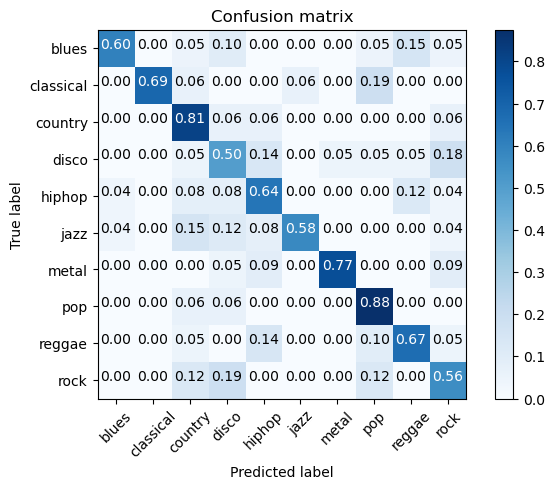

In [32]:
from collections import OrderedDict

print('Confusion Matrix Calculating ...')
preds = np.argmax(model.predict(X_test),axis=1)
y_orig = np.argmax(y_test,axis=1)
cm = confusion_matrix(preds, y_orig)

genres={'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8, 'rock':9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plot_confusion_matrix(cm,keys,normalize=True)
plt.show()

In [25]:
filename="C:/Users/alexa/Documents/Studium/Bachelor/Data4/genres_original/metal/metal.00000.wav"
audio,sr=librosa.load(filename,res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

#model.predict_classes(mfccs_scaled_features)
print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
pred_class=np.argmax(predicted_label,axis=1)

print(pred_class)
prediction_class=labelencoder.inverse_transform(pred_class)
prediction_class

[-52.940296    50.09013    -11.491269    46.324932     6.5430007
  10.116378     5.4855285    8.844898     5.9299426    6.625154
  -4.0330343    9.778293    -3.1172316    3.653597    -6.502195
   1.0854731   -4.482196     4.709674    -2.755327     0.4985645
  -9.29338      2.0262656   -3.4876702    2.5047514   -4.658039
  -1.8967493   -5.6836166   -3.1856866   -4.818261     0.85869867
  -5.738822    -0.4105425   -5.2758536    0.46732435  -0.6027184
  -0.65776074  -2.4302607    1.9490243   -4.047967    -2.8445647 ]
[[-52.940296    50.09013    -11.491269    46.324932     6.5430007
   10.116378     5.4855285    8.844898     5.9299426    6.625154
   -4.0330343    9.778293    -3.1172316    3.653597    -6.502195
    1.0854731   -4.482196     4.709674    -2.755327     0.4985645
   -9.29338      2.0262656   -3.4876702    2.5047514   -4.658039
   -1.8967493   -5.6836166   -3.1856866   -4.818261     0.85869867
   -5.738822    -0.4105425   -5.2758536    0.46732435  -0.6027184
   -0.65776074  -2.4

array(['metal'], dtype='<U9')

## References

From: StudyGyaan. (2021, June 28). GTZAN Dataset - Music Genre Classification using Python [Video]. YouTube. Retrieved April 20, 2023, from https://www.youtube.com/watch?v=2mCfP6mpQpo



From: Ahmad, F., & Sahil, N. (2019) Plot_CM.py [Source Code] (Accessed April 23, 2023) https://github.com/sahilsharma884/Music-Genre-Classification/blob/master/Plot_CM.py

From: Ahmad, F., & Sahil, N. (2019) CNN_Model.py [Source Code] (Accessed April 23, 2023) https://github.com/sahilsharma884/Music-Genre-Classification/blob/master/CNN_Model.py